#### 1. Problema: Seleccionar una variable categórica como factor y una variable continua como variable dependiente

Supongan que están interesados en investigar si hay diferencias significativas en la variable dependiente entre al menos tres grupos que ustedes escojan de la base de datos del "Census at School".

**Pasos:**

1. **Análisis de Varianza (ANOVA)**: Primero, realizar un ANOVA para determinar si hay diferencias significativas en la variable dependiente entre los diferentes grupos. Deben proporcionar el código de cómo llegaron a las tablas de resumen y ANOVA (ver ejemplo en clase).
2. **Post-ANOVA**: Si el resultado del ANOVA es significativo, realizar un análisis post-hoc para determinar qué grupos específicos difieren en la variable dependiente. Usar la prueba LSD de Fisher.
3. **Intervalos de Confianza**: Calcular los intervalos de confianza para las diferencias en la variable dependiente entre los grupos. Esto les dará una idea de la incertidumbre asociada a las estimaciones de las diferencias.
4. **Gráficas**: Finalmente, visualizar los resultados utilizando un boxplot de la variable dependiente entre los diferentes grupos para visualizar las diferencias. También crear un gráfico de los intervalos de confianza para visualizar la incertidumbre de las estimaciones.

In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [15]:
df = pd.read_csv('../data/cleandata/datasetcleaned.csv')

In [16]:
df = df[~df["Planned_Education_Level"].isnull()]

In [17]:
df = df[df["Height_cm"] < 220]
df = df [df["Ageyears"] < 24]
df = df [df["Height_cm"] > 100]

                                   sum_sq      df         F    PR(>F)
C(Planned_Education_Level)    1763.137933     5.0  2.710332  0.019224
Residual                    141163.841965  1085.0       NaN       NaN
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------
      Graduate degree           High school    4.555 0.0079   0.7753  8.3346   True
      Graduate degree Less than high school   2.1391 0.9975 -11.2114 15.4896  False
      Graduate degree                 Other   0.9505 0.9861  -3.1578  5.0588  False
      Graduate degree          Some college   1.0513 0.9625  -2.5767  4.6794  False
      Graduate degree  Undergraduate degree   1.7653 0.5507  -1.2487  4.7794  False
          High school Less than high school  -2.4158 0.9961 -16.1817 11.3501  False
          High school             

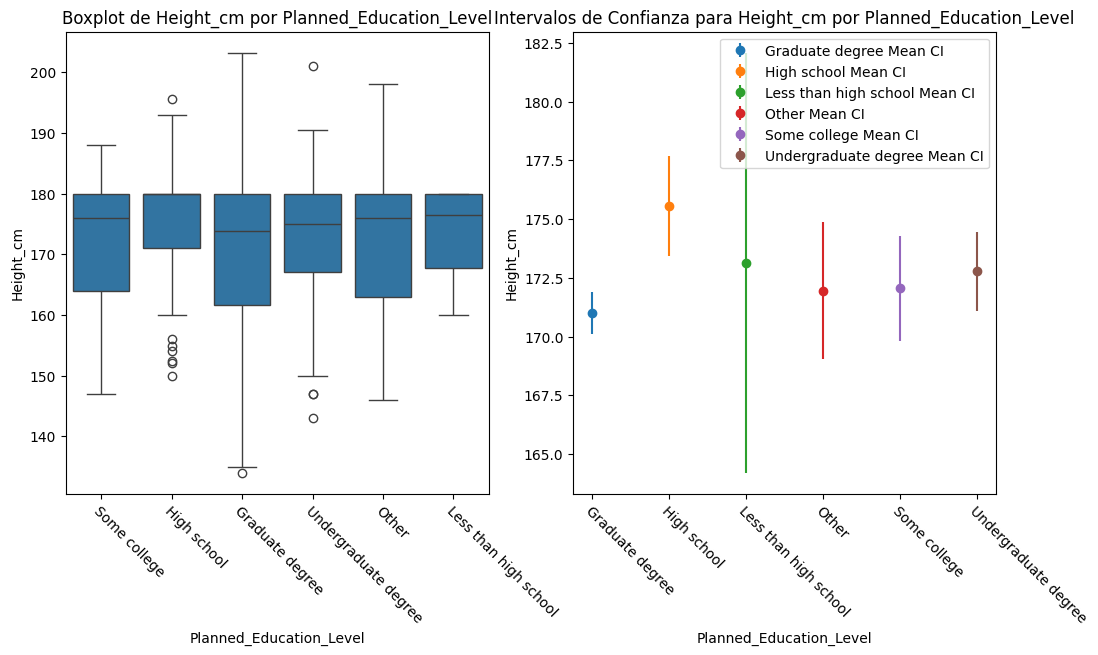

In [18]:
df['Planned_Education_Level'] = df['Planned_Education_Level'].astype('str')
df['Height_cm'] = df['Height_cm'].astype('float')

# Eliminar filas con valores NaN en las columnas relevantes
df = df.dropna(subset=['Planned_Education_Level', 'Height_cm'])

# ANOVA
model = ols('Height_cm ~ C(Planned_Education_Level)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Post-ANOVA (Prueba LSD de Fisher)

tukey = pairwise_tukeyhsd(endog=df['Height_cm'],
                        groups=df['Planned_Education_Level'],
                        alpha=0.05)
print(tukey)

# Intervalos de Confianza
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = data.mean(), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return pd.Series([m, m-h, m+h], index=['mean', 'mean - h', 'mean + h'])

confidence_intervals = df.groupby('Planned_Education_Level')['Height_cm'].apply(mean_confidence_interval).unstack()
print(confidence_intervals)

# Gráficas
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='Planned_Education_Level', y='Height_cm', data=df)
plt.title('Boxplot de Height_cm por Planned_Education_Level')
plt.setp(plt.subplot(1,2,1).get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")

# Gráfico de Intervalos de Confianza
plt.subplot(1, 2, 2)
for level in confidence_intervals.index:
    plt.errorbar(level, confidence_intervals.loc[level, 'mean'], 
                yerr=[[confidence_intervals.loc[level, 'mean'] - confidence_intervals.loc[level, 'mean - h']], 
                    [confidence_intervals.loc[level, 'mean + h'] - confidence_intervals.loc[level, 'mean']]], 
                fmt='o', label=f'{level} Mean CI')
                
plt.setp(plt.subplot(1,2,2).get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.title('Intervalos de Confianza para Height_cm por Planned_Education_Level')
plt.xlabel('Planned_Education_Level')
plt.ylabel('Height_cm')
plt.legend()
plt.show()